<a href="https://colab.research.google.com/github/eshal26/custom_vgg/blob/main/custom_vgg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import os
import shutil
import sklearn
from sklearn.model_selection import train_test_split

<h2>Data Preprocessing</h2>

In [17]:

# Define paths to dataset directories
train_dir = 'train_dataset'
val_dir = 'validation_dataset'
test_dir = 'test_dataset'

# Define transformations for training, validation, and testing data
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.8245, 0.8547, 0.9387], std = [0.1323, 0.1431, 0.0530])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.8245, 0.8547, 0.9387], std = [0.1323, 0.1431, 0.0530])
])

# Create datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=val_test_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=val_test_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

<h2>Define Model</h2>

In [18]:
import torch.nn.functional as F

# Define the CustomVGG model as a function
def create_custom_vgg(num_classes=2):
    def forward(x):
        x = F.relu(conv1(x))
        x = F.max_pool2d(x, 2, 2)  # Output: 112x112x64

        x = F.relu(conv2(x))
        x = F.max_pool2d(x, 2, 2)  # Output: 56x56x128

        x = dropout1(x)
        x = flatten(x)

        x = F.relu(fc1(x))
        x = dropout2(x)

        x = fc2(x)

        return x

    # Define the model components
    conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)  # Output: 224x224x64
    conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)  # Output: 224x224x128

    dropout1 = nn.Dropout(p=0.25)
    dropout2 = nn.Dropout(p=0.5)

    flatten = nn.Flatten()

    fc1 = nn.Linear(128 * 56 * 56, 512)  # Adjusted for 224x224 input size
    fc2 = nn.Linear(512, num_classes)  # num_classes=2

    # Define the model as a Sequential container
    model = nn.Sequential(conv1, nn.ReLU(), nn.MaxPool2d(2, 2),
                          conv2, nn.ReLU(), nn.MaxPool2d(2, 2),
                          dropout1, flatten,
                          fc1, nn.ReLU(), dropout2,
                          fc2)

    return model

# Create the model
model = create_custom_vgg(num_classes=2)
print(model)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Dropout(p=0.25, inplace=False)
  (7): Flatten(start_dim=1, end_dim=-1)
  (8): Linear(in_features=401408, out_features=512, bias=True)
  (9): ReLU()
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=512, out_features=2, bias=True)
)


In [15]:
from collections import Counter

# Extract labels from the train dataset
all_labels = [label for _, label in train_dataset]

# Convert to a numpy array
all_labels = np.array(all_labels)

# Print unique labels and counts
unique_labels, counts = np.unique(all_labels, return_counts=True)
print(f"Unique Labels: {unique_labels}")
print(f"Counts: {counts}")

# Calculate class weights
num_samples = len(all_labels)
num_classes = len(unique_labels)
class_counts = Counter(all_labels)
class_weights = {class_id: num_samples / (num_classes * count) for class_id, count in class_counts.items()}
class_weights_tensor = torch.tensor([class_weights[i] for i in range(num_classes)], dtype=torch.float32)

print(f"Class Weights: {class_weights}")
print(f"Class Weights Tensor: {class_weights_tensor}")

Unique Labels: [0 1]
Counts: [ 352 1926]
Class Weights: {0: 3.2357954545454546, 1: 0.5913811007268951}
Class Weights Tensor: tensor([3.2358, 0.5914])


In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define a loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor.to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

<h2>Training loop</h2>

In [21]:
# Lists to store metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        # Training phase
        for images, labels in train_loader:
            # Move data to the device
            images, labels = images.to(device), labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)

            # Compute the loss
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Update statistics
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

        # Calculate average loss and accuracy for this epoch
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = 100 * correct_predictions / total_samples
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)
        print(f"Epoch {epoch+1}/{num_epochs}: Training Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct_predictions = 0
        val_total_samples = 0

        with torch.no_grad():
            for images, labels in val_loader:
                # Move data to the device
                images, labels = images.to(device), labels.to(device)

                # Forward pass
                outputs = model(images)

                # Compute the loss
                loss = criterion(outputs, labels)

                # Update validation statistics
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                val_correct_predictions += (predicted == labels).sum().item()
                val_total_samples += labels.size(0)

        # Calculate average loss and accuracy for validation
        val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = 100 * val_correct_predictions / val_total_samples
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")

    # Save the model
    torch.save(model.state_dict(), 'custom_vgg_model.pth')
    print("Model saved as 'custom_vgg_model.pth'")

# Call the train_model function
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20)

Epoch 1/20: Training Loss: 2.9742, Accuracy: 79.63%
Validation Loss: 0.3277, Accuracy: 78.53%
Epoch 2/20: Training Loss: 0.4904, Accuracy: 78.62%
Validation Loss: 0.2785, Accuracy: 84.25%
Epoch 3/20: Training Loss: 0.4308, Accuracy: 78.71%
Validation Loss: 0.6750, Accuracy: 51.33%
Epoch 4/20: Training Loss: 0.5139, Accuracy: 60.01%
Validation Loss: 0.5387, Accuracy: 60.12%
Epoch 5/20: Training Loss: 0.4199, Accuracy: 73.13%
Validation Loss: 0.3941, Accuracy: 74.85%
Epoch 6/20: Training Loss: 0.4000, Accuracy: 74.67%
Validation Loss: 0.5547, Accuracy: 65.64%
Epoch 7/20: Training Loss: 0.3749, Accuracy: 76.47%
Validation Loss: 0.3610, Accuracy: 77.10%
Epoch 8/20: Training Loss: 0.3362, Accuracy: 81.08%
Validation Loss: 0.5488, Accuracy: 72.60%
Epoch 9/20: Training Loss: 0.3589, Accuracy: 79.41%
Validation Loss: 0.4210, Accuracy: 76.69%
Epoch 10/20: Training Loss: 0.3218, Accuracy: 82.22%
Validation Loss: 0.2995, Accuracy: 82.21%
Epoch 11/20: Training Loss: 0.2775, Accuracy: 86.52%
Valida

<h2>Plotting Accuracy and Loss</h2>

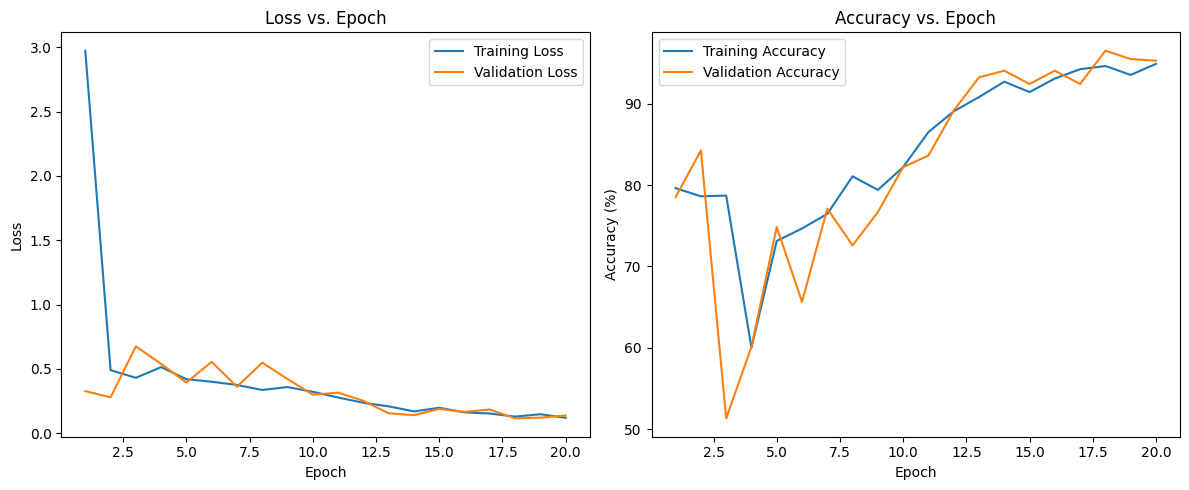

In [24]:
import matplotlib.pyplot as plt

# Define the number of epochs
num_epochs = 20

# Plot training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs. Epoch')
plt.legend()

plt.tight_layout()
plt.show()


<h2>Evaluating Model</h2>

In [25]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

def evaluate_model(model, test_loader, device):
    # Set the model to evaluation mode
    model.eval()

    # Lists to store true labels and predicted labels
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            # Move data to the device
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)

            # Get the predictions
            _, preds = torch.max(outputs, 1)

            # Append true labels and predictions to the lists
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Convert lists to numpy arrays
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    # Calculate metrics
    accuracy = (all_preds == all_labels).mean()
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)
    cr = classification_report(all_labels, all_preds)

    # Print the metrics
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print("Confusion Matrix:")
    print(cm)
    print("Classification Report:")
    print(cr)

# Call the evaluate_model function
evaluate_model(model, test_loader, device)


Accuracy: 0.96
Precision: 0.96
Recall: 0.96
F1 Score: 0.96
Confusion Matrix:
[[ 69   7]
 [ 13 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.91      0.87        76
           1       0.98      0.97      0.98       413

    accuracy                           0.96       489
   macro avg       0.91      0.94      0.92       489
weighted avg       0.96      0.96      0.96       489



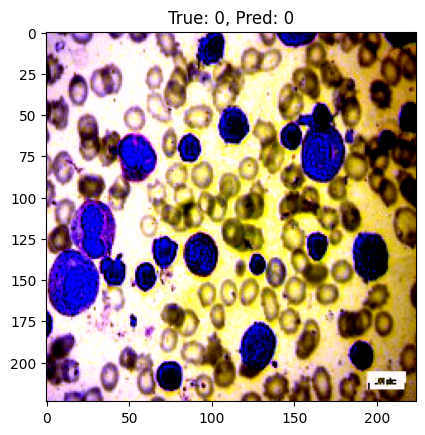

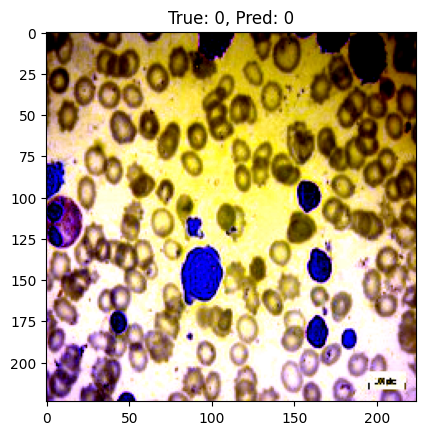

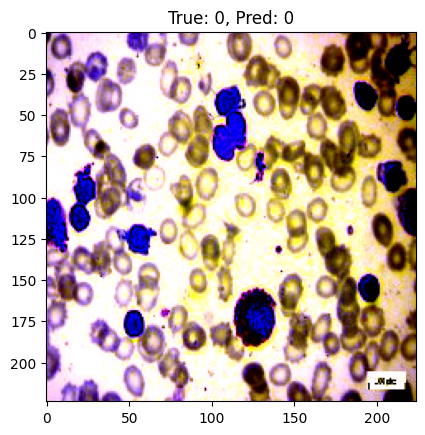

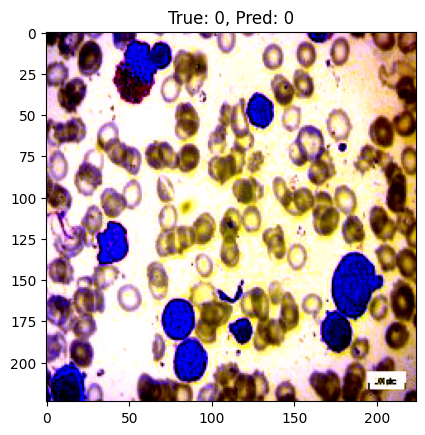

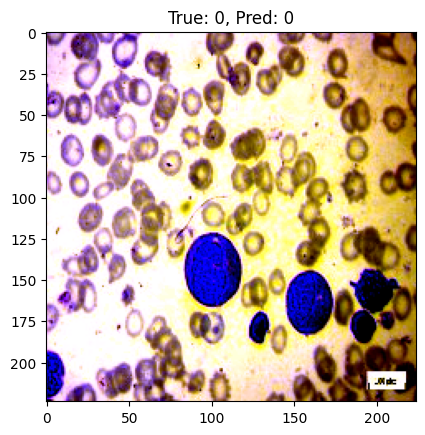

In [26]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img, title=None):
    # Convert the tensor to a numpy array and unnormalize
    img = img / 2 + 0.5  # Unnormalize the image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Convert CHW to HWC format
    if title is not None:
        plt.title(title)
    plt.show()

def view_evaluated_samples(model, test_loader, num_samples=5):
    model.eval()
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)  # Move data to device

    outputs = model(images)
    _, preds = torch.max(outputs, 1)

    # Get a few samples to display
    for i in range(num_samples):
        img = images[i].cpu()  # Move the image back to CPU for displaying
        label = labels[i].cpu().item()
        pred = preds[i].cpu().item()
        # Create a title string with true label and predicted label
        title = f'True: {label}, Pred: {pred}'
        imshow(img, title)

# Call the function to view evaluated samples
view_evaluated_samples(model, test_loader, num_samples=5)
